# Решение задачи поиска оттоковых клиентов

* Загрузка данных и их анализ
* Обучение и оценка качества модели
  + обучение модели
  + оценка качества модели
* Интерпретация результатов модели
* Сохранение результатов

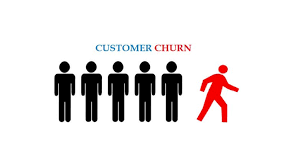

В курсе мы будем пользоваться следующими библиотеками Python:

*   Pandas - библиотеки для работы с таблицами
*   Numpy - библиотеки для быстрых и эффективных вычислений
*   Matplotlib - для визуализации данных
*   Sklearn - библиотеки с основными инструментами ML

С функционалом этих библиотек разберемся в процессе прохождения курса.

Будем решать задачу определения оттоковых клиентов,  а именно, *по характеристикам клиентов некоторого банка будем определять, собираются ли клиенты сменить оператора мобильной связи или нет*.

## <font color='green'>1. Загрузка данных и их первичный анализ</font>

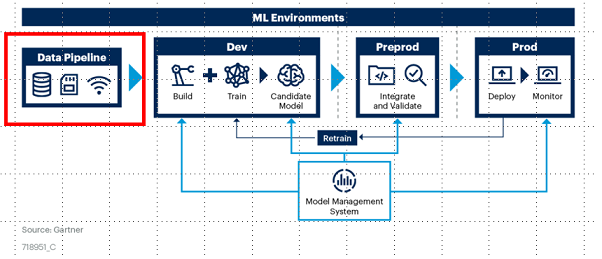

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

In [2]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2023-02-20 22:05:14--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2023-02-20 22:05:15 (651 MB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



In [3]:
!sudo apt update && sudo apt install --yes python3 python3-pip && \
!pip3 install psycopg2-binary

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu focal InRelease
Get:8 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ Packages [71.6 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:12 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [998 kB]
Get:13 http://archiv

In [4]:
import psycopg2

conn = psycopg2.connect("""
    host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
    port=6432
    sslmode=verify-full
    dbname=db_clients
    user=mlhs_student
    password=mlhs_student
    target_session_attrs=read-write
""")

In [77]:
import pandas as pd

query = "SELECT * from public.credit_scoring"
data = pd.read_sql_query(query, conn)


# Описание данных скоринг:

* **SeriousDlqin2yrs**: Клиент имел просрочку 90 и более дней


* **RevolvingUtilizationOfUnsecuredLines**: Общий баланс средств (общий баланс по кредитным картам и личным кредитным линиям, за исключением недвижимости и задолженности без рассрочки, такой как автокредиты, деленный на сумму кредитных лимитов).
* **age**: Возраст заемщика
* **NumberOfTime30-59DaysPastDueNotWorse**: Сколько раз за последние 2 года наблюдалась просрочка 30-59 дней.
* **DebtRatio**: Ежемесячные расходы (платеж по долгам, алиментам, расходы на проживания) деленные на месячный доход.
* **MonthlyIncome**: Ежемесячный доход.
* **NumberOfOpenCreditLinesAndLoans**: Количество открытых кредитов (напрмер, автокредит или ипотека) и кредитных карт.
* **NumberOfTimes90DaysLate**: Сколько раз наблюдалась просрочка (90 и более дней).
* **NumberRealEstateLoansOrLines**: Количество кредиов (в том числе под залог жилья)
* **NumberOfTime60-89DaysPastDueNotWorse**: Сколько раз за последние 2 года заемщик задержал платеж на 60-89 дней.
* **NumberOfDependents**: Количество иждивенцев на попечении (супруги, дети и др).





In [6]:
data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [7]:
data.shape

(150000, 11)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

In [78]:
data = data.drop_duplicates()

In [10]:
data.shape

(149391, 11)

In [65]:
data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,138134.000000,138134.000000,138134.000000,138134.000000,138134.000000,1.125210e+05,138134.000000,138134.000000,138134.000000,138134.000000,135204.000000
mean,0.070801,6.329356,49.987367,0.416762,367.236600,6.763581e+03,8.545782,0.255020,1.062845,0.227402,0.807114
std,0.256493,258.514038,12.696775,3.995290,2102.039347,1.467954e+04,5.141557,3.969399,1.137622,3.953304,1.139373
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.035793,40.000000,0.000000,0.188884,3.475000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.176700,50.000000,0.000000,0.372668,5.488000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.590270,60.000000,0.000000,0.833530,8.333000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,74.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [79]:
age_median = data[data.age.between(21, 74)].age.median()

Кредит могут получить граждани от 21 года, заменим возраст на медианный для тех строк у которых age < 21

In [60]:
data[data.age < 21].head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
65695,0,1.0,0,1,0.436927,6000.0,6,0,2,0,2.0


In [80]:
data['age'].mask(data['age'] < 21, age_median, inplace=True)

In [18]:
data[data.age < 21].head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents


Так же кредит как правило выдают до определенного возраста (в зависимости от политики банка) в нашем примере установим это ограничение до 75 лет

In [81]:
data = data[data.age < 75]

Глядя на данные можно заметить, что есть большие выбросы по полям MonthlyIncome, DebtRatio и RevolvingUtilizationOfUnsecuredLines. Проверим первую гипотизу и выкинем такие данные из нашей таблицы. Основываясь на том, что данные слишком завышены и клиенты с такими даннымы не являются целевыми для нашей модели, для них стоит использовать отдельную модель.

In [82]:
data_1 = data[(data.MonthlyIncome < 20001) & (data.DebtRatio <= 1) & (data.RevolvingUtilizationOfUnsecuredLines <= 1)]

In [46]:
data_1.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,101062.000000,101062.000000,101062.000000,101062.000000,101062.000000,101062.000000,101062.000000,101062.000000,101062.000000,101062.000000,101062.000000
mean,0.063417,0.324282,49.439473,0.386179,0.317504,6405.277503,8.696107,0.221369,1.034672,0.199482,0.889810
std,0.243712,0.337537,12.621080,3.736185,0.221338,3655.369496,5.089699,3.705901,1.041678,3.692450,1.160577
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.038020,40.000000,0.000000,0.149692,3708.000000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.180971,50.000000,0.000000,0.290393,5666.000000,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.557848,59.000000,0.000000,0.449751,8345.000000,11.000000,0.000000,2.000000,0.000000,2.000000
max,1.000000,1.000000,74.000000,98.000000,1.000000,20000.000000,57.000000,98.000000,20.000000,98.000000,20.000000


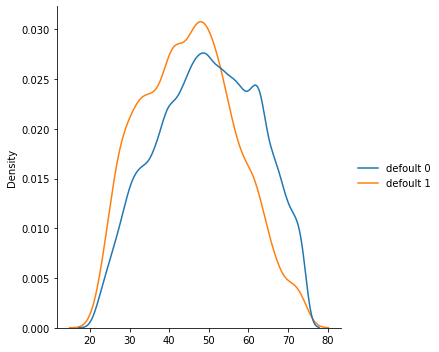

In [83]:
from numpy.lib.type_check import common_type
import seaborn as sns
sns.displot({
    "defoult 0":data_1[data_1.SeriousDlqin2yrs==0].age,
    "defoult 1":data_1[data_1.SeriousDlqin2yrs==1].age,
    }, kind="kde", common_norm=False)

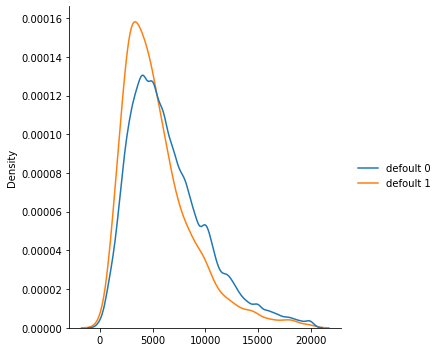

In [49]:
sns.displot({
    "defoult 0":data_1[data_1.SeriousDlqin2yrs==0].MonthlyIncome,
    "defoult 1":data_1[data_1.SeriousDlqin2yrs==1].MonthlyIncome,
    }, kind="kde", common_norm=False)

Добавим несколько фич.
В поле **costs** посчитаем реальную сумму которую тратит заемщик.

In [84]:
data_1["costs"] = data_1['DebtRatio'] * data_1['MonthlyIncome']

Так же добавим фичу care - где отобразим сколько средств уходит на одного члена семьи.

In [54]:
data_1["care"] = data_1['MonthlyIncome'] / (data_1['NumberOfDependents'] + 1)

In [85]:
data_1

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,costs
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,7323.197016
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,316.878123
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,258.914887
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,118.963951
5,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0,1314.624392
...,...,...,...,...,...,...,...,...,...,...,...,...
149994,0,0.385742,50,0,0.404293,3400.0,7,0,0,0,0.0,1374.595707
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0,472.774869
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0,4001.283436
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0,0.000000


In [86]:
corr = data_1.corr()
corr.style.background_gradient(cmap='coolwarm')

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,costs
SeriousDlqin2yrs,1.000000,0.242173,-0.088812,0.122026,0.047642,-0.065746,-0.036785,0.113987,-0.027175,0.098583,0.038314,0.005555
RevolvingUtilizationOfUnsecuredLines,0.242173,1.000000,-0.228781,0.112800,0.128378,-0.121614,-0.182320,0.101331,-0.108471,0.089120,0.065813,0.049696
age,-0.088812,-0.228781,1.000000,-0.047056,0.013047,0.195028,0.237755,-0.048553,0.153589,-0.044965,-0.151037,0.105897
NumberOfTime30-59DaysPastDueNotWorse,0.122026,0.112800,-0.047056,1.000000,-0.034807,-0.040502,-0.050189,0.980193,-0.031606,0.983782,-0.001297,-0.029392
DebtRatio,0.047642,0.128378,0.013047,-0.034807,1.000000,-0.071309,0.355129,-0.054931,0.527984,-0.050086,0.079815,0.656491
MonthlyIncome,-0.065746,-0.121614,0.195028,-0.040502,-0.071309,1.000000,0.302297,-0.049068,0.418675,-0.043997,0.185289,0.571917
NumberOfOpenCreditLinesAndLoans,-0.036785,-0.182320,0.237755,-0.050189,0.355129,0.302297,1.000000,-0.075977,0.415175,-0.066317,0.036243,0.475631
NumberOfTimes90DaysLate,0.113987,0.101331,-0.048553,0.980193,-0.054931,-0.049068,-0.075977,1.000000,-0.046096,0.991888,-0.007472,-0.050125
NumberRealEstateLoansOrLines,-0.027175,-0.108471,0.153589,-0.031606,0.527984,0.418675,0.415175,-0.046096,1.000000,-0.039746,0.116324,0.739648
NumberOfTime60-89DaysPastDueNotWorse,0.098583,0.089120,-0.044965,0.983782,-0.050086,-0.043997,-0.066317,0.991888,-0.039746,1.000000,-0.008251,-0.043875


Удалим из данных коррелирующие поля.

In [87]:
data_1 = data_1.drop(['DebtRatio','NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse','NumberRealEstateLoansOrLines', 'NumberOfDependents', 'MonthlyIncome'],axis=1)

In [98]:
corr = data_1.corr()
corr.style.background_gradient(cmap='coolwarm')

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,costs
SeriousDlqin2yrs,1.000000,0.242173,-0.088812,-0.065746,-0.036785,0.113987,0.005555
RevolvingUtilizationOfUnsecuredLines,0.242173,1.000000,-0.228781,-0.121614,-0.182320,0.101331,0.049696
age,-0.088812,-0.228781,1.000000,0.195028,0.237755,-0.048553,0.105897
MonthlyIncome,-0.065746,-0.121614,0.195028,1.000000,0.302297,-0.049068,0.571917
NumberOfOpenCreditLinesAndLoans,-0.036785,-0.182320,0.237755,0.302297,1.000000,-0.075977,0.475631
NumberOfTimes90DaysLate,0.113987,0.101331,-0.048553,-0.049068,-0.075977,1.000000,-0.050125
costs,0.005555,0.049696,0.105897,0.571917,0.475631,-0.050125,1.000000


Сформируем матрицу X объект-признак и вектор y целевой переменной.

In [89]:
y = data_1['SeriousDlqin2yrs']
X = data_1.drop('SeriousDlqin2yrs', axis=1)

Мы разбиваем данные на train и test, чтобы:

на тренировочных данных обучить модель
на тестовых применить обученную модель и затем проверить качество модели

In [90]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

Отмасштабируем признаки при помощи StandardScaler, обучив метод на тренировочных данных и применив его и к трейну, и к тесту.

In [91]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(Xtrain)

Xtrain = pd.DataFrame(ss.transform(Xtrain), columns=X.columns)
Xtest = pd.DataFrame(ss.transform(Xtest), columns=X.columns)

Xtrain.head()

,RevolvingUtilizationOfUnsecuredLines,age,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,costs
0,-0.959265,0.283710,-0.663527,-0.135918,-0.059447,-0.508677
1,-0.710215,0.046006,-0.612865,-0.332861,-0.059447,-1.127379
2,-0.952666,-0.667108,-0.382832,1.242680,-0.059447,-1.163529
3,-0.599174,-0.112464,-0.896299,-0.726746,-0.059447,-0.067245
4,-0.937036,-1.380222,-0.645727,-1.317574,-0.059447,-0.941886


Обучим логистическую регрессию на train и сделаем предсказание на новых для нее данных (test).

In [92]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression() # объявление модели
model.fit(Xtrain, ytrain) # обучение модели

LogisticRegression()

In [93]:
pred_test = model.predict(Xtest) # предсказание классов

In [94]:
pred_test

array([0, 0, 0, ..., 0, 0, 0])

In [95]:
accuracy_score(ytest, pred_test)  # 0.9342199002612206

0.9342199002612206

Проверим, сбалансирована ли выборка.

In [96]:
y.value_counts()

0    94653
1     6409
Name: SeriousDlqin2yrs, dtype: int64

In [97]:
from sklearn.metrics import confusion_matrix

confusion_matrix(ytest, pred_test)

array([[23584,    13],
       [ 1649,    20]])

In [71]:
ytest.value_counts()

0    23597
1     1669
Name: SeriousDlqin2yrs, dtype: int64

In [72]:
from sklearn.metrics import recall_score

recall_score(ytest, pred_test)

0.011983223487118035

In [74]:
from sklearn.metrics import precision_score

precision_score(ytest, pred_test)

0.6060606060606061

In [73]:
probs = model.predict_proba(Xtest)

probs[:10]

array([[0.93234369, 0.06765631],
       [0.96332775, 0.03667225],
       [0.83822595, 0.16177405],
       [0.83277529, 0.16722471],
       [0.83833921, 0.16166079],
       [0.97541502, 0.02458498],
       [0.91235913, 0.08764087],
       [0.97139632, 0.02860368],
       [0.7872574 , 0.2127426 ],
       [0.98075812, 0.01924188]])

In [75]:
model.coef_, model.intercept_

(array([[ 0.84509522, -0.15229518,  0.17296579,  0.09514255,  0.0563159 ,
         -0.21582549]]), array([-3.11765017]))

In [76]:
coef_table = pd.DataFrame({'features' : list(X.columns), 'weights' : list(model.coef_[0])})

coef_table.sort_values(by='weights')

,features,weights
5,care,-0.215825
1,age,-0.152295
4,costs,0.056316
3,NumberOfTimes90DaysLate,0.095143
2,NumberOfOpenCreditLinesAndLoans,0.172966
0,RevolvingUtilizationOfUnsecuredLines,0.845095


In [99]:
conn.close()